# Feature Selection
This notebook looks at the correlation between features used in the support vector machine (SVM) classification of the phase scintillation index, $\sigma_\phi$. 2015 data is used throughout, looking at data for the Fort McMurray (mcm) CHAIN station, which performed best in the SVM classification model (spaceweather.ipynb).

The SVM is a classifier which often produces accurate and reliable results. However, the time required to train an SVM increases as more data points are fed to the classifier. In order to reduce the training time, dimensionality reduction can be used. Dimensionality reduction is the process of reducing the number of features in a data set, while preserving as much information as possible. This is done in such a way that the variance is maximised. Finding a lower-dimensional representation of the data set can improve both the efficiency and accuracy when the data is fed to machine learning (ML) models.

Below, the importance of features in the data set is determined by using PCA, Fisher Ranking, Extra Tree Classification, Logistic Regression, a Decision Tree Classifier and Random Forests. 

## 1 Preprocessing
### 1.1 Load Data

In [1]:
\c 12 110
\l /SpaceWeather/kxdb
\l ../sw1/funcs.q
\l ../sw1/graphics.q
\l ../sw1/configSVM.q

sdate:2015.01.01;
edate:2015.12.31;

In [2]:
show complete:raze{[dt]
 `chain1`solar1 set'{({exec colname from configSVM where table=x}each y)#select from y where date=x}[dt;]each`chain`solar;
 merged:select from(chain1 lj`dt xkey update solarmatch:1b from solar1)where solarmatch;
 select from merged where cs=`mcm
 }peach sdate+til 1+edate-sdate

dt                      doy chainStation TECcurrent dTEC_15s SI    specSlope S4ver      sigPhiVer  sigPhiVe..
-----------------------------------------------------------------------------------------------------------..
2015.01.01T00:01:00.000 1   mcm          35.12      -0.042   0.006 1.79      0.02449711 0.02454222 0.021294..
2015.01.01T00:02:00.000 1   mcm          34.453     -0.043   0.006 1.86      0.02343506 0.02284805 0.023147..
2015.01.01T00:03:00.000 1   mcm          33.472     -0.038   0.008 1.8       0.02378979 0.02076649 0.024199..
2015.01.01T00:04:00.000 1   mcm          35.129     -0.019   0.007 1.82      0.02751854 0.02349132 0.019881..
2015.01.01T00:05:00.000 1   mcm          37.152     -0.025   0.007 1.76      0.02503223 0.02353182 0.019358..
2015.01.01T00:06:00.000 1   mcm          37.933     -0.012   0.008 1.79      0.02641087 0.02067236 0.022570..
2015.01.01T00:07:00.000 1   mcm          35.672     -0.023   0.009 1.73      0.02867466 0.02057464 0.021135..
..


### 1.2 Drop nulls and scale
As there are large gaps in the data set, the null rows will be dropped with remaining data is scaled. Specified features will be $log(1+x)$ scaled to account for negative values and outliers.

In [3]:
complete@:where not any flip null complete;
scaled:flip(exec first scaler by colname from configSVM)@'flip complete;
xdata:flip stdscaler each flip(exec colname from configSVM where feature)#complete;
ydata:log exec sigPhiVer1hr from complete;

### 1.3 Import python libraries

In [5]:
array:.p.import[`numpy][`:array];
PCA:  .p.import[`sklearn.decomposition]`:PCA;
plt:  .p.import[`matplotlib]`:pyplot;

## 2 Principal Component Analysis (PCA)
PCA uses variance to determine the most important features in the data. The graph below plots the cumulative explained variance ratio (green) compared with the explained variance ratio (blue). The explained variance is the ratio between the variance of each component compared with the sum of variances of all the components, while the cumulative variance for component n is the total variance for the first n components. The plot allows the minimum amount of features to be chosen which reduce the dimensionality while keeping data loss to a minimum.

In [6]:
pcaall:PCA[`n_components pykw count cols xdata];
pcaall[`:fit_transform]array[value flip xdata]`:T;

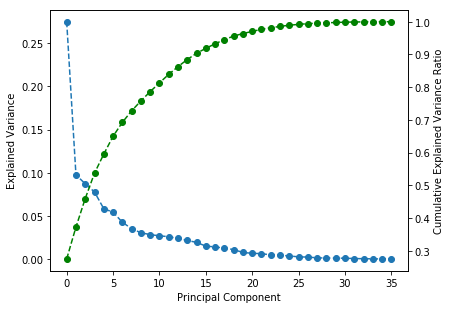

In [7]:
plt[`:subplots][];
plt[`:plot][pcaall[`:explained_variance_ratio_]`;`marker pykw`o;`ls pykw"--"];
plt[`:xlabel]"Principal Component";
plt[`:ylabel]"Explained Variance";
ax0:plt[`:gca][];
ax1:ax0[`:twinx][];
ax1[`:plot][pcaall[`:explained_variance_ratio_][`:cumsum][]`;`marker pykw`o;`ls pykw"--";`color pykw`g];
ax1[`:set_ylabel]"Cumulative Explained Variance Ratio";array[value flip xdata]`:T;
plt[`:show][];

The first 15 components hold the most variance in the data, so we will keep these features and and perform PCA again.

In [43]:
pca:PCA[`n_components pykw 15];
pca[`:fit_transform]array[value flip xdata]`:T;
ypos:til count cols xdata;
-1"The shape of pcacomp for all features is ",sv[" x "]string shape pcacomp:pca[`:components_]`;

The shape of pcacomp for all features is 15 x 36


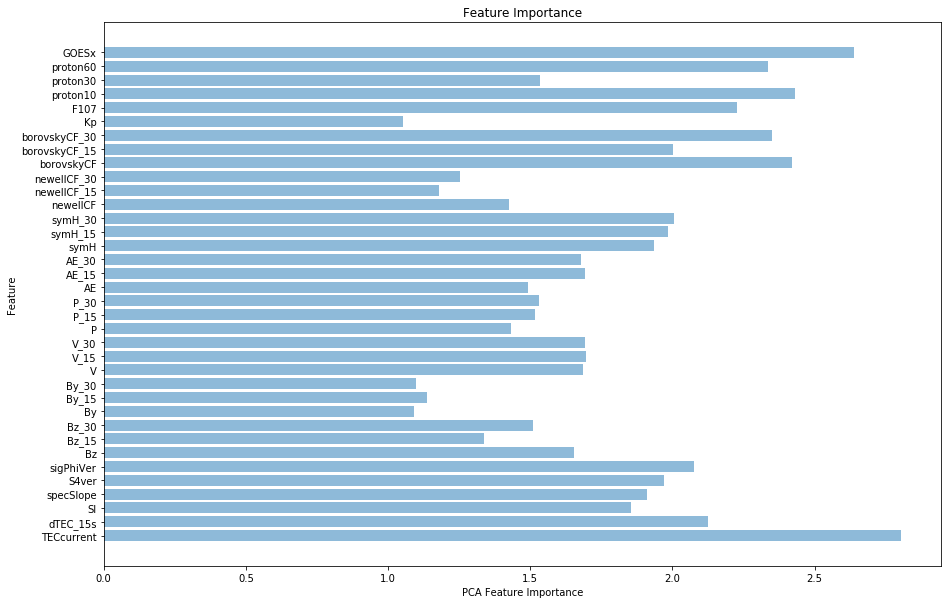

In [11]:
plt[`:subplots]`figsize pykw 15 10;
plt[`:barh][ypos;test:sum abs pcacomp;`align pykw "center"; `alpha pykw 0.5];
plt[`:yticks][ypos;cols xdata];
plt[`:ylabel]"Feature";
plt[`:title]"Feature Importance";
plt[`:xlabel]"PCA Feature Importance";
plt[`:show][];

The graph above shows the feature importance associated with each of the principal components of the SVM dataset. The top ten most important features can be extracted from the graph and printed below.

In [12]:
-1"Ten most important features:\n\n",", " sv string toptenpca:10#exec col from `testval xdesc flip `ypos`testval`col!(ypos;test;cols xdata);

Ten most important features:

TECcurrent, GOESx, proton10, borovskyCF, borovskyCF_30, proton60, F107, dTEC_15s, sigPhiVer, symH_30


## 3 Fisher ranking
The Fisher score is a feature selection algorithm used to determine the most important features in a data set. It assigns a score to each component, determining the number of features which should remain in the data set based on their score. This is done using the python scikit-learn SelectKBest library and the f_classif function, which determines the F-score for each component.

In [13]:
selectkbest:.p.import[`sklearn.feature_selection]`:SelectKBest
fclassif:   .p.import[`sklearn.feature_selection]`:f_classif

In [14]:
fsmodel:selectkbest[`score_func pykw fclassif];
fsmodel[`:fit_transform][array[value flip xdata]`:T;ydata];
show scores:fsmodel[`:scores_]`;
order:iasc scores;
orderfeat:{(cols xdata)x}each order;

1.052376 2.557858 1.199398 2.28643 1.063056 4.47624 1.772096 1.746211 1.711191 1.231553 1.245199 1.231923 1..


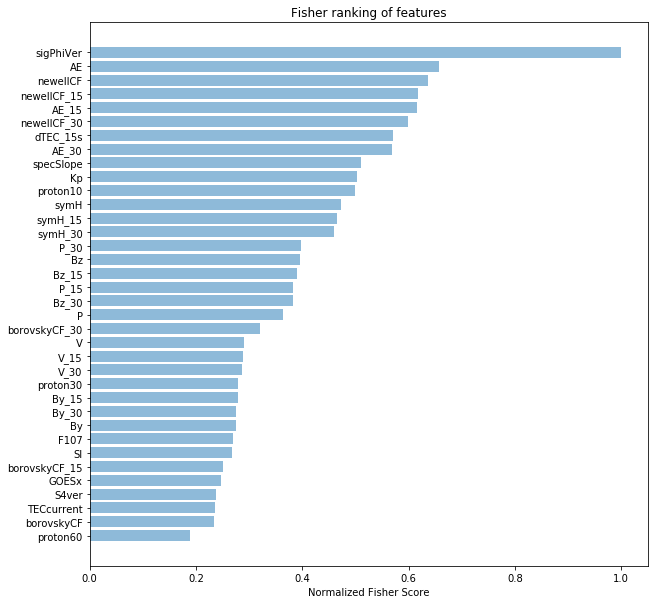

In [41]:
plt[`:subplots]`figsize pykw 10 10;
plt[`:barh][ypos;orderscore:asc scores%max scores;`align pykw`center;`alpha pykw 0.5];
plt[`:yticks][ypos;orderfeat];
plt[`:xlabel]"Normalized Fisher Score";
plt[`:title]"Fisher ranking of features";
plt[`:show][];

The graph above ranks the principal components in ascending order based on their Fisher Ranking score.

In [17]:
-1"Ten most important features:\n\n",", " sv string toptenfish:10#exec col from `orderedscore xdesc flip `ypos`orderedscore`col!(ypos;orderscore;orderfeat);

Ten most important features:

sigPhiVer, AE, newellCF, newellCF_15, AE_15, newellCF_30, dTEC_15s, AE_30, specSlope, Kp


## 4 Extra Tree Classification
Extra tree classifiers work by selecting features at random from a decision tree, in order to increase accuracy and control over-fitting within a model. They work similarly to random forests, but with a different data split, where for an extra trees classification, feature splitting is chosen at random, compared to the random forest method of choosing the best split among a subset of features. Important features among the data set can then be scored based on the results of the decision tree outcomes. Results are shown in the graph below, with feature importance in ascending order based on the individual scores. The most important features are again listed below.

In [18]:
extratree:.p.import[`sklearn.ensemble]`:ExtraTreesClassifier
selectmod:.p.import[`sklearn.feature_selection]`:SelectFromModel

In [19]:
clftree:extratree[];
clftree:clftree[`:fit][array[value flip xdata]`:T;ybin:ydata>.1];
ordertree:iasc clftree[`:feature_importances_]`
orderfeatlabels:{(cols xdata)x}each ordertree

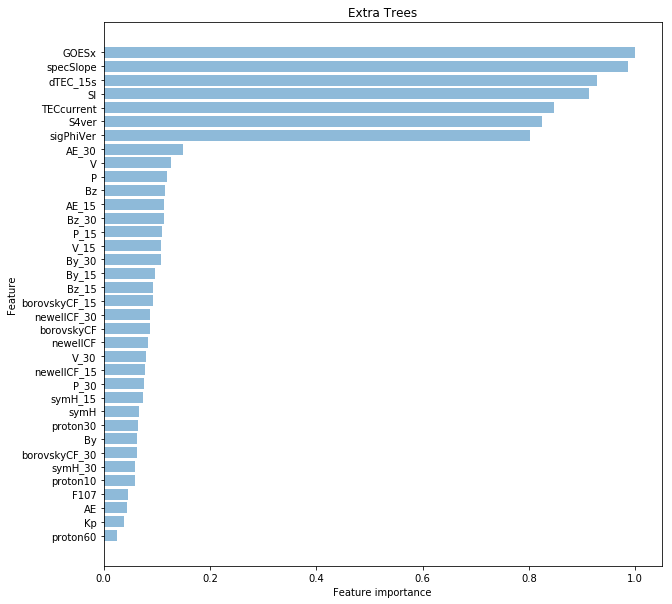

In [22]:
plt[`:subplots]`figsize pykw 10 10;
plt[`:barh][ypos;treescore:asc (100*clftree[`:feature_importances_]`)%(100*max clftree[`:feature_importances_]`);`align pykw`center;`alpha pykw 0.5];
plt[`:yticks][ypos;orderfeatlabels];
plt[`:xlabel]"Feature importance";
plt[`:ylabel]"Feature";
plt[`:title]"Extra Trees";
plt[`:show][];

In [23]:
-1"Ten most important features:\n\n",", " sv string toptentree:10#exec col from `treescore xdesc flip `ypos`treescore`col!(ypos;treescore;orderfeatlabels);

Ten most important features:

GOESx, specSlope, dTEC_15s, SI, TECcurrent, S4ver, sigPhiVer, AE_30, V, P


## 5 Logistic Regression - Recursive Feature Elimination
Logistic regression is commonly used in ML for binary classifications. Logistic regression uses probabilities in order to calculate the relationship between the desired predicted outcome and the input features from the data set. This probabilities can then be used to rank the importance of features in the data set. This method returns a list of selected features, as opposed to a list of descending feature importance. 

In [24]:
RFE:   .p.import[`sklearn.feature_selection]`:RFE
logreg:.p.import[`sklearn.linear_model]`:LogisticRegression

In [44]:
modelRFE:logreg[]
rfe:RFE[modelRFE]
fit:rfe[`:fit][array[value flip xdata]`:T;ybin]
-1"Num Features:\n",string fit[`:n_features_]`;
-1"\nSelected Features:\n",sv[" "]string where fit[`:support_]`;
-1"\nFeature Ranking:\n",sv[" "]string fit[`:ranking_]`;

Num Features:
18

Selected Features:
0 4 7 12 13 14 17 18 19 20 21 22 26 30 31 33 34 35

Feature Ranking:
1 12 13 14 1 6 10 1 4 11 15 18 1 1 1 17 7 1 1 1 1 1 1 8 9 3 1 5 19 16 1 1 2 1 1 1


In [27]:
-1"Most important features:\n\n",", " sv string toplog:(cols xdata)where fit[`:support_]`;

Most important features:

TECcurrent, S4ver, Bz_15, V, V_15, V_30, P_30, AE, AE_15, AE_30, symH, symH_15, newellCF_30, Kp, F107, proton30, proton60, GOESx


## 6 Decision Tree Classifier
Decision tree classifiers are predictive models which, given features as inputs, use a decision tree to represent the different possible outcomes in a classification problem. The models use branch nodes to describe observations about the inputs and leaves to represent the classification result. Feature importance can be calculated by assessing the outcome achieved when each feature is used as an input. The feature importance of the dataset is graphed below.

In [28]:
decisiontree:.p.import[`sklearn.tree]`:DecisionTreeClassifier

In [29]:
dtmodel:decisiontree[`random_state pykw 0]
dtclf:dtmodel[`:fit][array[value flip xdata]`:T;ybin]

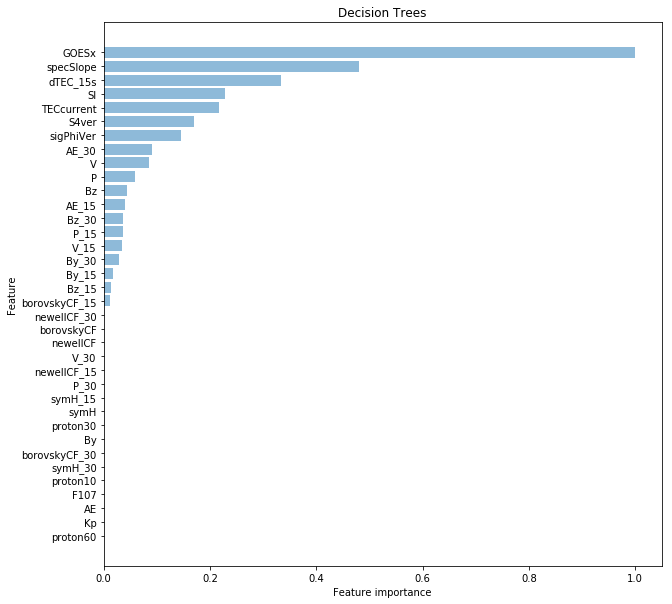

In [30]:
plt[`:subplots][`figsize pykw 10 10];
plt[`:barh][ypos;decscore:asc (100*dtclf[`:feature_importances_]`)%(100*max dtclf[`:feature_importances_]`);`align pykw "center"; `alpha pykw 0.5];
plt[`:yticks][ypos;orderfeatlabels];
plt[`:xlabel]"Feature importance";
plt[`:ylabel]"Feature";
plt[`:title]"Decision Trees";
plt[`:show][];

In [31]:
-1"Ten most important features:\n\n",", " sv string toptendec:10#exec col from `decscore xdesc flip `ypos`decscore`col!(ypos;decscore;orderfeatlabels);

Ten most important features:

GOESx, specSlope, dTEC_15s, SI, TECcurrent, S4ver, sigPhiVer, AE_30, V, P


## 7 Random Forest
A random forest is a supervised ML algorithm, which build a model based on multiple random decision trees, and combines results to increase the accuracy of the model. The split at each node is decided based on the best split of a subset of features. Using this algorithm, feature importance can also be extracted for each component. This is done by looking at the results of each node of the decision tree, and assessing if the features associated with this node increases the accuracy of the overall decision tree, or not. A score is then assigned to each feature, which is represented in the graph below. 

In [32]:
randomforest:.p.import[`sklearn.ensemble]`:RandomForestClassifier
clfrandom:randomforest[`random_state pykw 0]
clfrndm:clfrandom[`:fit][array[value flip xdata]`:T;ybin]

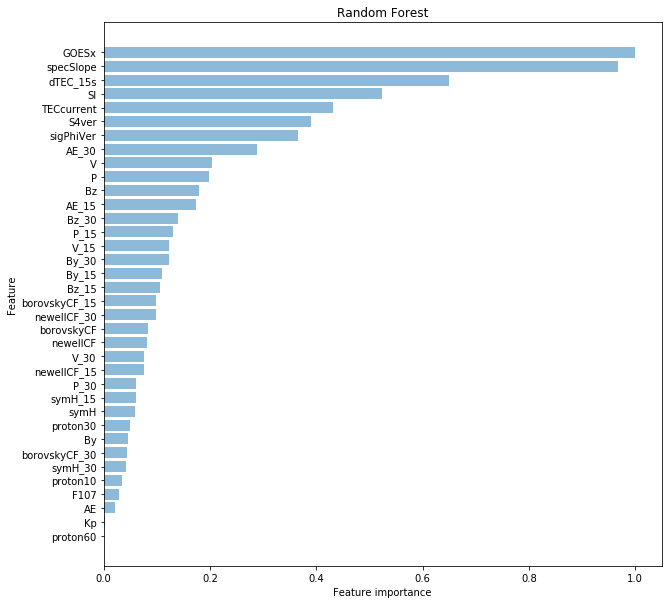

In [33]:
plt[`:subplots][`figsize pykw 10 10];
plt[`:barh][ypos;ranscore:asc [clfrndm[`:feature_importances_]`]%max clfrndm[`:feature_importances_]`;`align pykw "center"; `alpha pykw 0.5];
plt[`:yticks][ypos;orderfeatlabels];
plt[`:xlabel]"Feature importance";
plt[`:ylabel]"Feature";
plt[`:title]"Random Forest";
plt[`:show][];

In [34]:
-1"Ten most important features:\n\n",", " sv string toptenran:10#exec col from `ranscore xdesc flip `ypos`ranscore`col!(ypos;ranscore;orderfeatlabels);

Ten most important features:

GOESx, specSlope, dTEC_15s, SI, TECcurrent, S4ver, sigPhiVer, AE_30, V, P


## 8 Overall Feature Importance
Below lists all of the features which have been selected in the different methods above. The number of times each of these are chosen is also listed. The features (and their time-lagged columns) which appear multiple times will be kept in the data set and will be used to train the neural network.

In [42]:
\c 200 110
desc count each group raze(toptenpca;toptenfish;toptentree;toplog;toptendec;toptenran)

TECcurrent   | 5
GOESx        | 5
dTEC_15s     | 5
sigPhiVer    | 5
AE_30        | 5
specSlope    | 4
S4ver        | 4
V            | 4
SI           | 3
P            | 3
proton60     | 2
F107         | 2
AE           | 2
AE_15        | 2
newellCF_30  | 2
Kp           | 2
proton10     | 1
borovskyCF   | 1
borovskyCF_30| 1
symH_30      | 1
newellCF     | 1
newellCF_15  | 1
Bz_15        | 1
V_15         | 1
V_30         | 1
P_30         | 1
symH         | 1
symH_15      | 1
proton30     | 1


*References*
1. https://www.hindawi.com/journals/cmmm/2013/849674/
2. https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
3. http://scikit-learn.org/stable/modules/ensemble.html
4. https://towardsdatascience.com/the-logistic-regression-algorithm-75fe48e21cfa